In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import torch, pickle, glob, itertools, random
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torch.utils.data as data_utils

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
TARGET_SIZE = 224
TARGET_SHAPE = (TARGET_SIZE, TARGET_SIZE)
BATCH_SIZE = 32

ROOT_DIR = "/home/avinash/Downloads/dataset/ji-faces"
WORKING_DIR = "/home/avinash/Downloads/dataset"

CHECKPOINT_PATH = f"{WORKING_DIR}/siamese_netowrk_v2.pth"

# Define data transformations
TRAIN_TRANSFORM = transforms.Compose([
    transforms.Resize(TARGET_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

VAL_TRANSFORM = transforms.Compose([
    transforms.Resize(TARGET_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
class TripletDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
    
    def __getitem__(self, index):
        img1, label1 = self.dataset[index]
        positive_index = torch.randint(0, len(self.dataset), (1,)).item()
        while positive_index == index:
            positive_index = torch.randint(0, len(self.dataset), (1,)).item()
        img2, label2 = self.dataset[positive_index]
        negative_index = torch.randint(0, len(self.dataset), (1,)).item()
        while negative_index == index or negative_index == positive_index:
            negative_index = torch.randint(0, len(self.dataset), (1,)).item()
        img3, label3 = self.dataset[negative_index]
        
        return self.transform(img1), self.transform(img2), self.transform(img3), torch.tensor([label1 != label2], dtype=torch.float32)
    
    def __len__(self):
        return len(self.dataset)

def create_dataset_v2():
    dataset = ImageFolder(ROOT_DIR)
    image_count = len(dataset)
    train_size = int(image_count * 0.8)
    val_size = image_count - train_size
    
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_dataset = TripletDataset(train_dataset, TRAIN_TRANSFORM)
    val_dataset = TripletDataset(val_dataset, VAL_TRANSFORM)
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

    print("Train Test Dataset Generation Completed")
    return train_dataloader, val_dataloader

In [6]:
train_dataset, val_dataset = create_dataset_v2()

Train Test Dataset Generation Completed


In [7]:
    def get_encoder():
        base_cnn = models.resnet50(weights='IMAGENET1K_V2')
        base_cnn.fc = nn.Linear(base_cnn.fc.in_features, 128)
        return base_cnn

In [8]:
class DistanceLayer(nn.Module):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, margin):
        super(DistanceLayer, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = torch.norm(anchor - positive, p=2, dim=1)
        distance_negative = torch.norm(anchor - negative, p=2, dim=1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return torch.mean(losses)

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.encoder = get_encoder()

    def forward(self, anchor, positive, negative):
        anchor_emb = self.encoder(anchor)
        positive_emb = self.encoder(positive)
        negative_emb = self.encoder(negative)
        return anchor_emb, positive_emb, negative_emb

In [10]:
class SiameseModel(nn.Module):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.optimizer = self.configure_optimizers()
        self.margin = margin
        self.loss_tracker = DistanceLayer(margin)
        self.lr_scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    def forward(self, data):
        anchor, positive, negative = data
        return self.siamese_network(anchor, positive, negative)

    def training_step(self, data):
        # Zero the gradients
        self.optimizer.zero_grad()

        # Compute the loss
        loss = self._compute_loss(data)

        # Compute gradients
        loss.backward()

        # Update weights
        self.optimizer.step()

        return loss

    def validation_step(self, data):
        loss = self._compute_loss(data)

        return loss
    
    def update_scheduler(self, loss):
        self.lr_scheduler.step(loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.siamese_network.parameters(), lr=0.001)
        return optimizer

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        anchor, positive, negative = data
        out_anchor, out_positive, out_negative = self.siamese_network(anchor, positive, negative)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = self.loss_tracker(out_anchor, out_positive, out_negative)
        
        return loss

In [11]:
siamese_network = SiameseNetwork().to(device)
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs for training')
    siamese_network = nn.DataParallel(siamese_network)

siamese_model = SiameseModel(siamese_network, margin=0.2)
siamese_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Using 2 GPUs for training


SiameseModel(
  (siamese_network): DataParallel(
    (module): SiameseNetwork(
      (encoder): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0

In [12]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False;
        
    def reset_count(self):
#         self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [13]:
def train_fn(train_loader, model):
    model.train()
    train_loss = 0.0
    for batch_idx, (anchor, positive, negative, _) in enumerate(tqdm(train_loader, bar_format="\033[31m{bar}\033[0m{percentage:3.0f}%|{n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]")):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        data = [anchor, positive, negative]
        output = model.training_step(data)
        train_loss += output.item()
    train_loss /= len(train_loader)
    return train_loss


def val_fn(val_loader, model):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (anchor, positive, negative, _) in enumerate(tqdm(val_loader, bar_format="\033[32m{bar}\033[0m{percentage:3.0f}%|{n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]")):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            data = [anchor, positive, negative]
            output = model.validation_step(data)
            val_loss += output.item()
    val_loss /= len(val_loader)
    return val_loss

In [14]:
if os.path.exists(CHECKPOINT_PATH):
    os.remove(CHECKPOINT_PATH)

In [15]:
early_stopping = EarlyStopping(patience=10, delta=0.0)
best_val_loss = float('inf')
epoch = 1

losses = []

while not early_stopping.early_stop:
    print("Epoch: ", epoch)
    train_loss = train_fn(train_dataset, siamese_model)
    val_loss = val_fn(val_dataset, siamese_model)
    losses.append({'train': train_loss, 'val': val_loss})

    siamese_model.update_scheduler(val_loss)
    early_stopping(val_loss)
    print("Train Loss: {}, Val Loss: {}".format(train_loss, val_loss))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(siamese_model.state_dict(), CHECKPOINT_PATH)
    epoch += 1

Epoch:  1


██████████100%|97/97 [01:57<00:00,  1.22s/it]
██████████100%|25/25 [00:14<00:00,  1.70it/s]


Train Loss: 0.2157673932535132, Val Loss: 0.241033616065979
Epoch:  2


██████████100%|97/97 [01:30<00:00,  1.07it/s]
██████████100%|25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.20912672210599959, Val Loss: 0.21625329196453094
Epoch:  3


██████████100%|97/97 [01:30<00:00,  1.08it/s]
██████████100%|25/25 [00:12<00:00,  1.96it/s]


Train Loss: 0.2060326620475533, Val Loss: 0.23509831190109254
Epoch:  4


██████████100%|97/97 [01:29<00:00,  1.08it/s]
██████████100%|25/25 [00:12<00:00,  2.03it/s]


Train Loss: 0.2061345426692176, Val Loss: 0.23296529233455657
Epoch:  5


██████████100%|97/97 [01:29<00:00,  1.08it/s]
██████████100%|25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.20558091061016948, Val Loss: 0.19943346977233886
Epoch:  6


██████████100%|97/97 [01:30<00:00,  1.07it/s]
██████████100%|25/25 [00:12<00:00,  2.03it/s]


Train Loss: 0.203384978408666, Val Loss: 0.2070850759744644
Epoch:  7


██████████100%|97/97 [01:30<00:00,  1.07it/s]
██████████100%|25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.2027402890404475, Val Loss: 0.22688617348670959
Epoch:  8


██████████100%|97/97 [01:29<00:00,  1.08it/s]
██████████100%|25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.20233857201546737, Val Loss: 0.20101224184036254
Epoch:  9


██████████100%|97/97 [01:29<00:00,  1.08it/s]
██████████100%|25/25 [00:12<00:00,  2.05it/s]


Train Loss: 0.2024091028982831, Val Loss: 0.20310624212026596
Epoch:  10


██████████100%|97/97 [01:29<00:00,  1.08it/s]
██████████100%|25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.2031209502638001, Val Loss: 0.22623368620872497
Epoch:  11


██████████100%|97/97 [01:29<00:00,  1.08it/s]
██████████100%|25/25 [00:11<00:00,  2.10it/s]


Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.
Train Loss: 0.20660882619852872, Val Loss: 0.20025090396404266
Epoch:  12


██████████100%|97/97 [01:29<00:00,  1.08it/s]
██████████100%|25/25 [00:12<00:00,  2.05it/s]


Train Loss: 0.19981246357111587, Val Loss: 0.19996401607990266
Epoch:  13


██████████100%|97/97 [01:29<00:00,  1.08it/s]
██████████100%|25/25 [00:12<00:00,  2.00it/s]


Train Loss: 0.2006923084713749, Val Loss: 0.20090712010860443
Epoch:  14


██████████100%|97/97 [01:29<00:00,  1.08it/s]
██████████100%|25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.20149324757536663, Val Loss: 0.20083784699440002
Epoch:  15


██████████100%|97/97 [01:31<00:00,  1.06it/s]
██████████100%|25/25 [00:12<00:00,  2.08it/s]

Train Loss: 0.20132651433502277, Val Loss: 0.1999332946538925


In [18]:
import matplotlib.pyplot as plt

def plot_model(entries, graph_type, file_path):
    train_values = [x['train'] for x in entries]
    eval_values = [x['val'] for x in entries]
    
    plt.plot(train_values,'-o')
    plt.plot(eval_values,'-o')
    plt.xlabel('Epoch')
    plt.ylabel(graph_type)
    plt.legend(['Train','Valid'])
    plt.title(f'Train vs Valid {graph_type}')
    plt.savefig(file_path)
    plt.show()

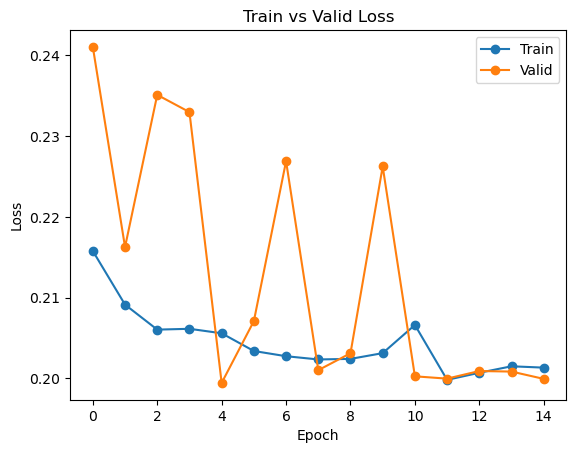

In [19]:
plot_model(losses, "Loss", f"{WORKING_DIR}/Siamese_Network_Loss.png")